In [100]:
import cupy as cp 
import numpy as np
import matplotlib.pyplot as plt
import time as t


n = 30000
nt = 100
dt = 0.01
T = nt * dt
A = 1

t0 = t.perf_counter()
trajs = cp.random.normal(size=(n, nt+1))
trajs = cp.cumsum(trajs, axis=1)
t1 = t.perf_counter()
trajs = (trajs).get()
#Make the nt+1 value = NaN
min_val = np.min(trajs)
max_val = np.max(trajs)
trajs[:, -1] = np.nan


In [101]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.datatypes import RaggedArray
from matplotlib import colors

In [102]:
# Optional colormaps
try:
    import colorcet as cc
    DENSITY_CMAP = cc.fire
except Exception:
    DENSITY_CMAP = "Blues"


def generate_image(
    data: np.ndarray,
    dt: float,
    n: int,
    nt: int,
    min_val:float,
    max_val:float,
    out_png="all_trajectories_overlay.png",
    plot_width=1400,
    plot_height=800,
    background="black",
    xlabel="Time(seconds)",
    ylabel="Displacement(arbitrary units)"
):
    n, nt = data.shape
    t = np.arange(nt, dtype=np.float32) * dt

    x_range = (0, dt*nt)
    y_range = (float(np.nanmin(data)), float(np.nanmax(data)))

    cvs = ds.Canvas(
        plot_width=plot_width,
        plot_height=plot_height,
        x_range=x_range,
        y_range=y_range,
    )

    df_all = pd.DataFrame({
        "time": np.tile(t, n),
        "val":  data.reshape(-1),
        "id":   np.repeat(np.arange(n), nt),
    })
    
    
    agg_all = cvs.line(df_all, x="time", y="val", agg=ds.count())

    img = tf.shade(agg_all, cmap=DENSITY_CMAP, how="log")
    img = tf.set_background(img, background)
    img = tf.dynspread(img, threshold=0.1, max_px=2)

    export_image(img, out_png.replace(".png", ""), fmt=".png")
    
    fig, ax = plt.subplots(figsize=(10, 5), dpi=150)

   
    ax.imshow(
        img.to_pil(),
        extent=[0, dt*(nt-1), min_val, max_val],
        origin="lower",
        aspect="auto",
    )
    ax.tick_params(colors="white")
    for spine in ax.spines.values():
        spine.set_color("white")
    ax.set_facecolor("black")
    ax.set_xlabel(xlabel, color="white")
    ax.set_ylabel(ylabel, color="white")
    fig.patch.set_facecolor("black")
    plt.title("All Trajectories", color="white")

    plt.tight_layout()
    plt.savefig("all_trajectories_overlay.png")
    

    return img



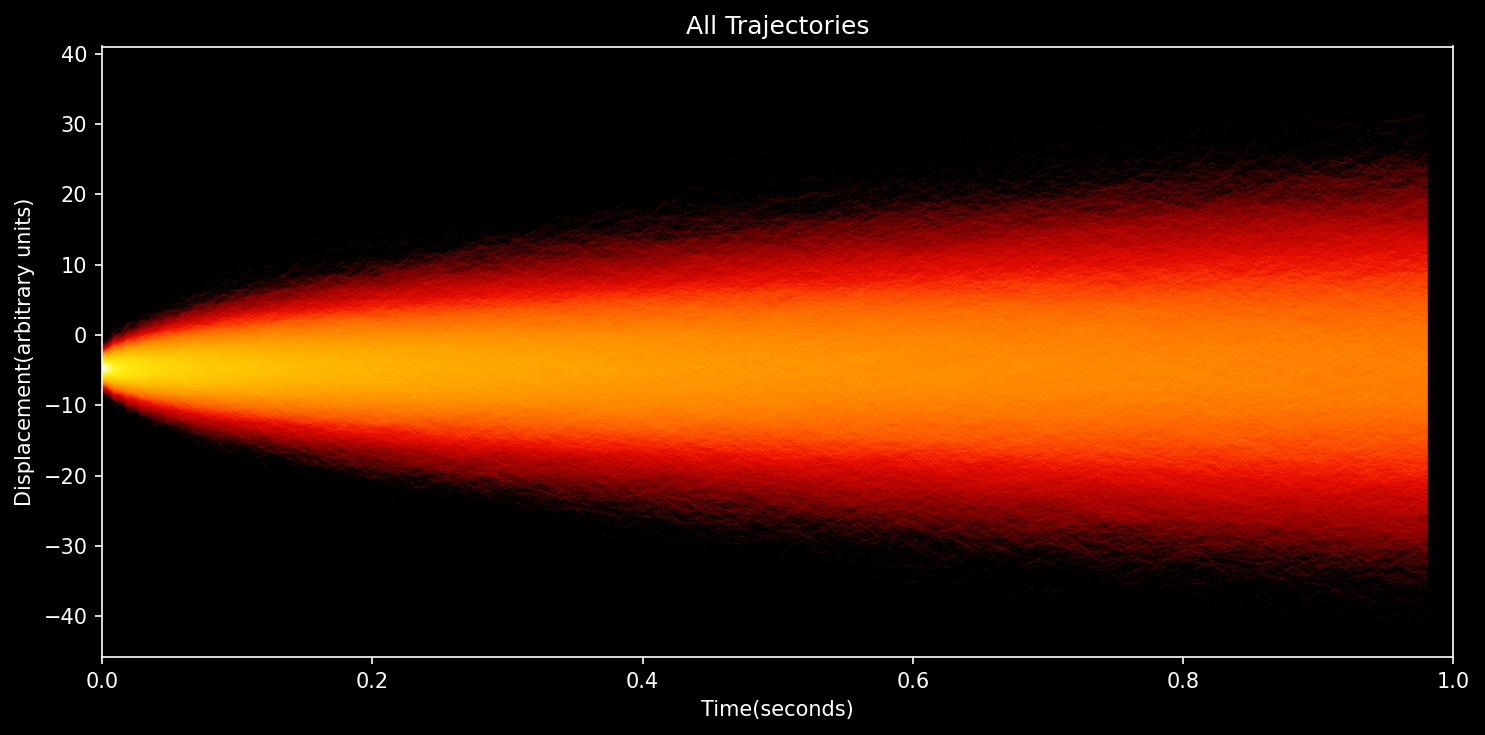

In [103]:

t0 = t.perf_counter()
trajs = cp.random.normal(size=(n, nt+1))
trajs = cp.cumsum(trajs, axis=1)
t1 = t.perf_counter()
trajs = (trajs).get()
#Make the nt+1 value = NaN
min_val = np.min(trajs)
max_val = np.max(trajs)
trajs[:, -1] = np.nan

generate_image(
    trajs,
    dt=dt,
    n=n,
    nt=nt,
    out_png="all_trajectories_overlay.png",
    plot_width=1600,
    plot_height=900,
    min_val=min_val,
    max_val=max_val,
);

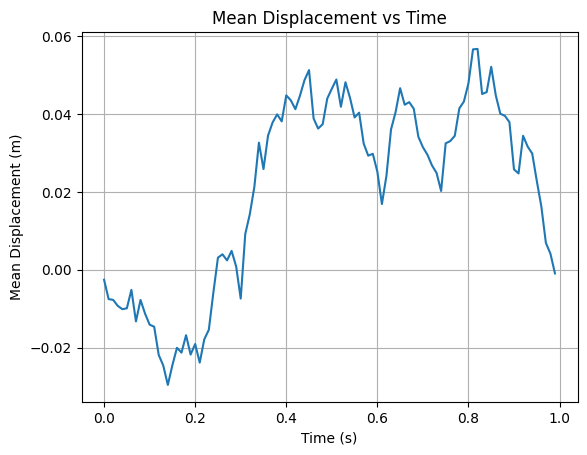

In [106]:
def plt_settings(title:str, xlabel:str, ylabel:str, colour:str='blue'):

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()



mean_displacement_vs_time = cp.mean(trajs, axis=0)
plt.plot(np.arange(nt+1)*dt, mean_displacement_vs_time)
plt_settings("Mean Displacement vs Time", "Time (s)", "Mean Displacement (m)")
# msd_vs_time = cp.square(trajs)

In [159]:
def perform_studies(n_min, n_factor, n_n, nt, dt):
    # mean_x_vals = []
    # mean_x_sq_vals = []
    plot_mean_x_vals, ax_mean = plt.subplots(figsize=(10, 5), dpi=150)
    plot_mean_x_sq_vals, ax_mean_sq = plt.subplots(figsize=(10, 5), dpi=150)

    time_vals = [i * dt for i in range(nt)]
    for i in range(1, n_n):
        n = n_min *(n_factor ** i)
        trajs = cp.random.normal(size=(n_min, nt))
        trajs = cp.cumsum(trajs, axis=1)
        # trajs = (trajs).get()
        min_val = cp.min(trajs)
        max_val = cp.max(trajs)
        trajs_mean = cp.mean(trajs, axis=0)
        # plot_mean_x_vals = plt.plot(time_vals, trajs_mean.get(), label=f"n={n}")
        ax_mean.plot(time_vals, trajs_mean.get(), label=f"n={n}")
        trajs_sq= cp.square(trajs)
        trajs_sq_mean = cp.mean(trajs_sq, axis=0)
        ax_mean_sq.plot(time_vals, trajs_sq_mean.get(), label=f"n={n}")


    # return plot_mean_x_vals
    ax_mean.legend()
    ax_mean_sq.legend()
    ax_mean.set_title("Mean Displacement vs Time for different n")
    ax_mean_sq.set_title("Mean Squared Displacement vs Time for different n")
    ax_mean.set_xlabel("Time (s)")
    ax_mean_sq.set_xlabel("Time (s)")
    ax_mean.set_ylabel("Mean Displacement (length_unit)")
    ax_mean_sq.set_ylabel("Mean Squared Displacement (length_unit^2)")

    plot_mean_x_sq_vals.show()


/tmp/ipykernel_251520/860440428.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_mean_x_sq_vals.show()


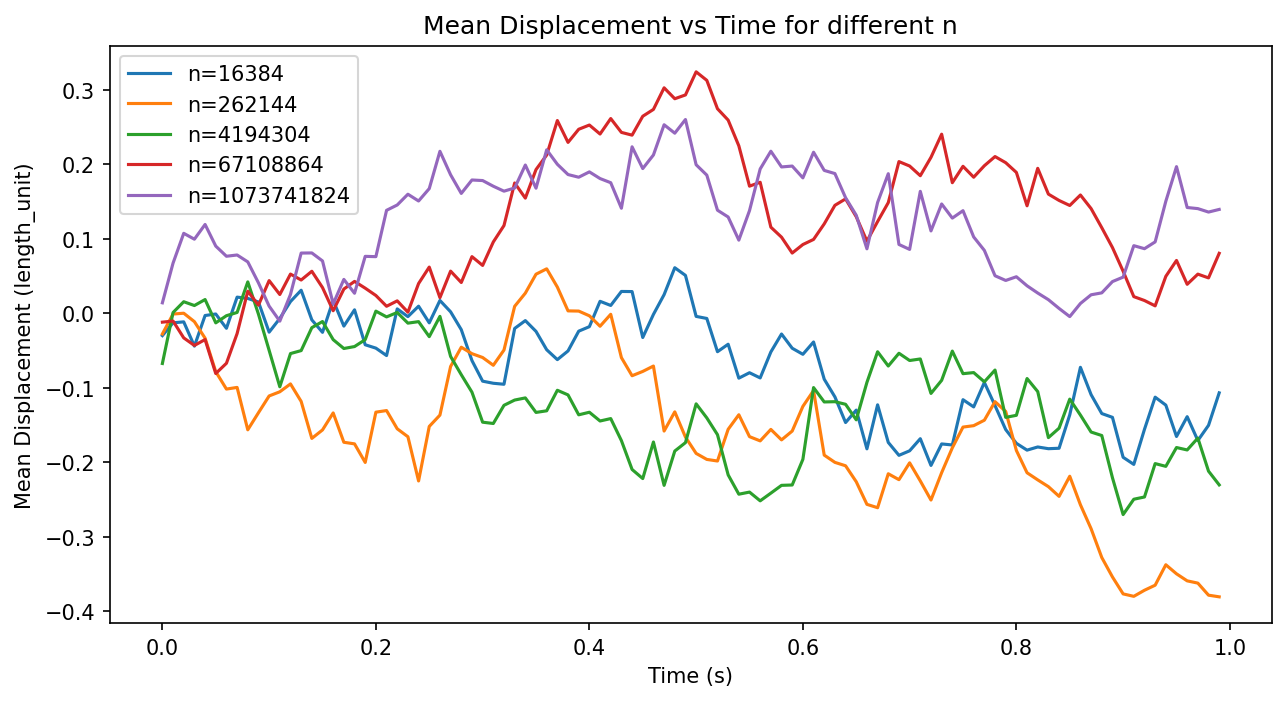

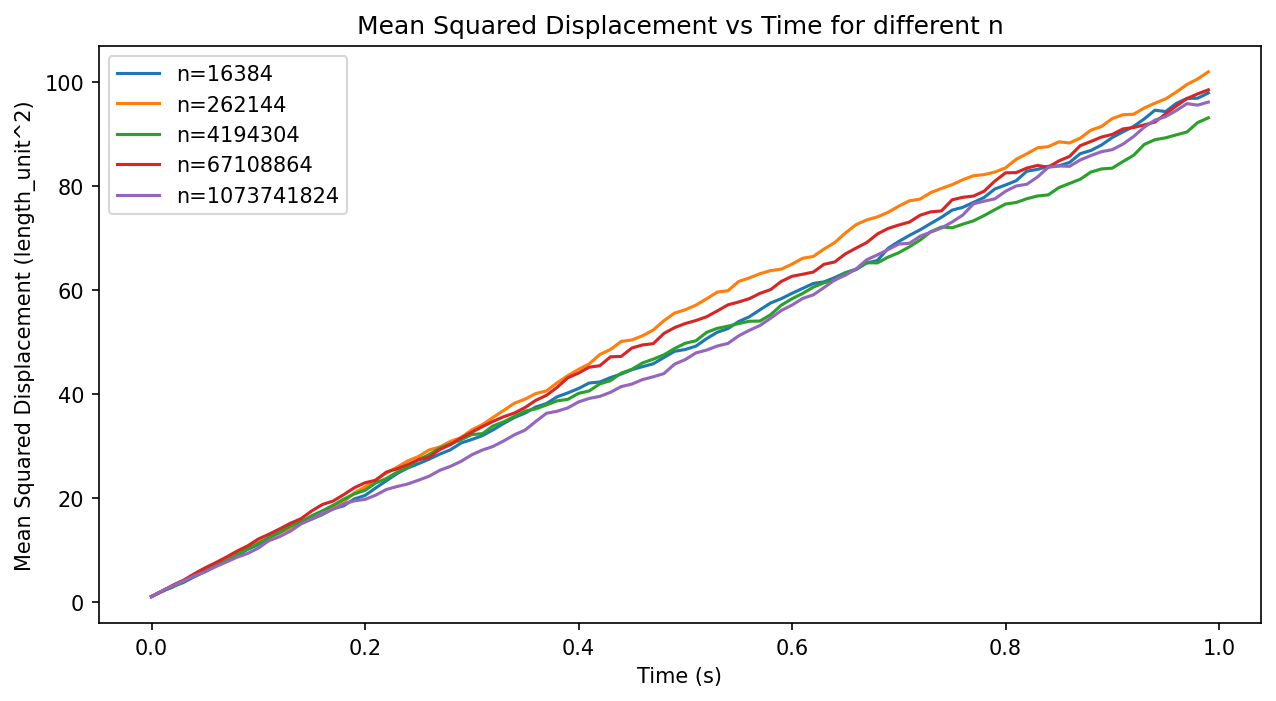

In [160]:
perform_studies(1024, 16, 6, nt, dt);

/tmp/ipykernel_251520/3953910182.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


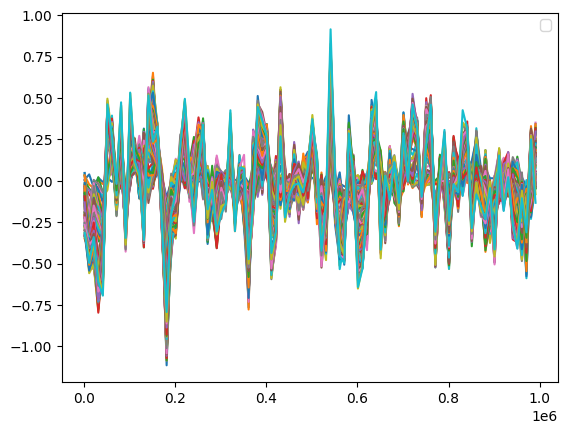

In [ ]:
plt.plot(np.arange(100)*10000 + 1000, mean_x_vals)
plt.legend()
plt.show()
# print(np.array(mean_x_vals).shape)